In [196]:
import gzip      
import pickle       
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
import pandas as pd


In [197]:
def mesh_index_to_km(x):
    return (x / 299) * 110

def km_to_mesh_index(x):
    return (x / 110) * 299

In [198]:
import numpy as np

def clean_grounding_line(gl_array):
    """
    Keep only the first contiguous block of 1s after a 0→1 transition.
    Everything after the first 0→1→0 pattern is zeroed out.
    """
    gl_array = np.array(gl_array).astype(int)
    output = np.zeros_like(gl_array)

    found = False
    start = None
    end = len(gl_array)  # default: assume 1s go to the end

    for i in range(1, len(gl_array)):
        if not found and gl_array[i-1] == 0 and gl_array[i] == 1:
            start = i
            found = True
        elif found and gl_array[i] == 0:
            end = i
            break

    if found and start is not None:
        output[start:end] = 1

    return output



In [199]:
def remove_spikes(gl_array, min_length=3):
    """
    Removes short floating spikes (1s) that are shorter than min_length.
    """
    arr = np.array(gl_array).astype(int)
    output = arr.copy()
    start = None

    for i in range(len(arr)):
        if arr[i] == 1 and start is None:
            start = i
        elif arr[i] == 0 and start is not None:
            if i - start < min_length:
                output[start:i] = 0  # erase short spike
            start = None

    return output


In [200]:
def get_GL_index(gl_array):
    gl_array = np.array(gl_array).astype(int)
    for i in range(1, len(gl_array)):
        if gl_array[i-1] == 0 and gl_array[i] == 1:
            return i
    return None

# AMPLITUDE TESTS

## Grounding Line Plotting - AMP 0 

In [201]:
gl_run_title_0 = str("Grounding Line Evolution Over Time - Bump Amplitude = 0")
amp_0 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_22__00_31_03.pkl.gz"
with gzip.open(amp_0, 'rb') as f:
    DATA_dict_amp0 = pickle.load(f)
    

In [202]:
bed_dict = DATA_dict_amp0['bed_dict']
base_dict = DATA_dict_amp0['base_dict']
surf_dict= DATA_dict_amp0 ['surf_dict']
sed_dict = DATA_dict_amp0['sed_dict']
H_dict = DATA_dict_amp0['H_dict']
us_dict = DATA_dict_amp0['us_dict']
ub_dict = DATA_dict_amp0['ub_dict']
Hs_dict = DATA_dict_amp0['Hs_dict']
GL_dict = DATA_dict_amp0['GL_dict']
Qs_dict = DATA_dict_amp0['Qs_dict']
final_time = list(GL_dict)[-1]
print(final_time)

20002.060034256905


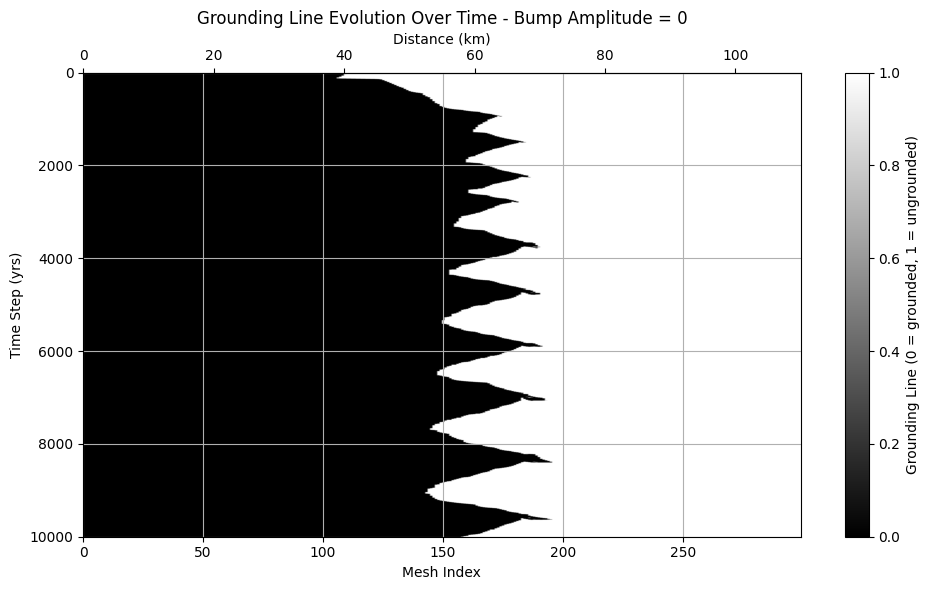

In [203]:
GL_dict = DATA_dict_amp0['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_0)
ax.set_ylim(10000)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.grid()
plt.show()

In [204]:
gl_positions_amp_0 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amp_0.append(idx)

gl_positions_amp_0 = np.array(gl_positions_amp_0)
GL_km_amp_0 = mesh_index_to_km(gl_positions_amp_0)

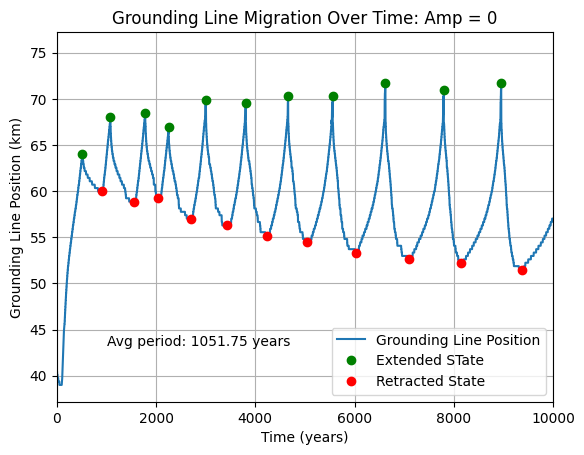

Mean cycle period: 1051.75 years
[5.62377454e+02 6.98131693e+02 4.75834047e+02 7.48195260e+02
 8.05382372e+02 8.55039169e+02 9.00708120e+02 1.05976023e+03
 1.17921920e+03 1.15673378e+03 1.37801551e+03 1.37943416e+00
 1.46726266e+03 1.86279053e+03 1.63110457e+01 2.18115399e+03
 3.57384753e+03 9.41256968e+00]
Mean advance amplitude: 70.89 km
[64.01337793 68.06020067 68.42809365 66.95652174 69.89966555 69.53177258
 70.26755853 70.26755853 71.73913043 71.00334448 71.73913043 72.84280936
 72.84280936 71.73913043 70.63545151 73.94648829 73.94648829 73.57859532
 75.4180602 ]
Mean retreat amplitude: 56.49 km
[59.96655518 58.86287625 59.23076923 57.02341137 56.28762542 55.18394649
 54.44816054 53.34448161 52.60869565 52.24080268 51.50501672 68.79598662
 51.13712375 50.40133779 68.06020067 50.03344482 48.92976589 68.79598662]


In [205]:
amp_0_peaks, _ = find_peaks(GL_km_amp_0, prominence=2) 
amp_0_troughs, _ = find_peaks(-GL_km_amp_0, prominence=2)     
amp_0_periods = np.diff(np.array(time)[amp_0_peaks])
amp_0_adv_dists = GL_km_amp_0[amp_0_peaks]
amp_0_ret_dists = GL_km_amp_0[amp_0_troughs]


plt.plot(time, GL_km_amp_0, label='Grounding Line Position')
plt.plot(np.array(time)[amp_0_peaks], GL_km_amp_0[amp_0_peaks], 'go', label='Extended STate')
plt.plot(np.array(time)[amp_0_troughs], GL_km_amp_0[amp_0_troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(amp_0_periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlim(0,10000)
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amp = 0")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(amp_0_periods):.2f} years")
print(amp_0_periods)

print(f"Mean advance amplitude: {np.mean(amp_0_adv_dists):.2f} km")
print(amp_0_adv_dists)

print(f"Mean retreat amplitude: {np.mean(amp_0_ret_dists):.2f} km")
print(amp_0_ret_dists)


## Grounding Line plotting - AMP 25

In [206]:
gl_run_title_25 = str("Grounding Line Evolution Over Time - Bump Amplitude = 25")
amp_25 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_23__10_42_19.pkl.gz"
with gzip.open(amp_25, 'rb') as f:
    DATA_dict_amp25 = pickle.load(f)

In [207]:
bed_dict = DATA_dict_amp25['bed_dict']
base_dict = DATA_dict_amp25['base_dict']
surf_dict= DATA_dict_amp25 ['surf_dict']
sed_dict = DATA_dict_amp25['sed_dict']
H_dict = DATA_dict_amp25['H_dict']
us_dict = DATA_dict_amp25['us_dict']
ub_dict = DATA_dict_amp25['ub_dict']
Hs_dict = DATA_dict_amp25['Hs_dict']
GL_dict = DATA_dict_amp25['GL_dict']
Qs_dict = DATA_dict_amp25['Qs_dict']

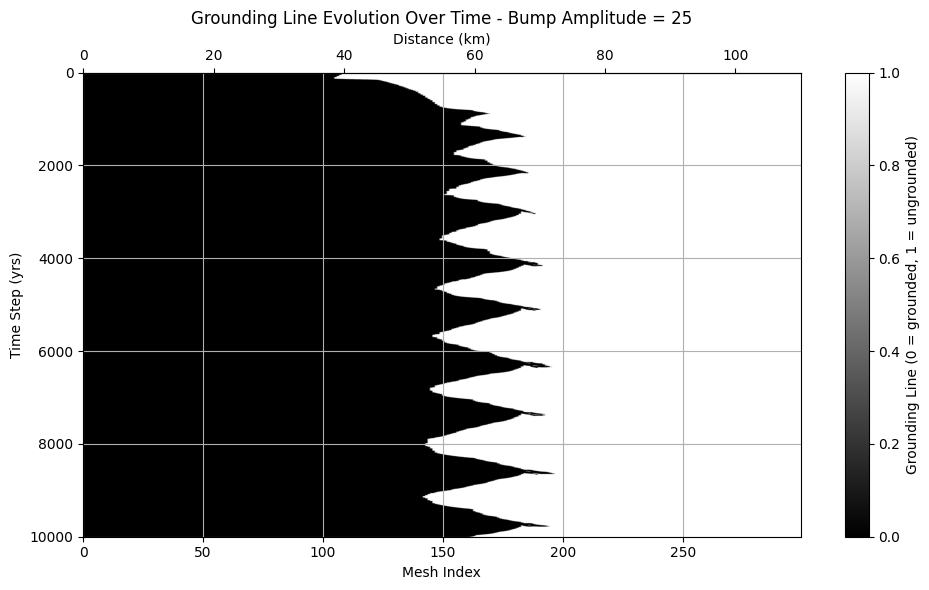

In [208]:
GL_dict = DATA_dict_amp25['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)
ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_25)
ax.set_ylim(10000)


# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.grid()
plt.show()

In [209]:
gl_positions_amp_25 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amp_25.append(idx)

gl_positions_amp_25 = np.array(gl_positions_amp_25)
GL_km_amp_25 = mesh_index_to_km(gl_positions_amp_25)

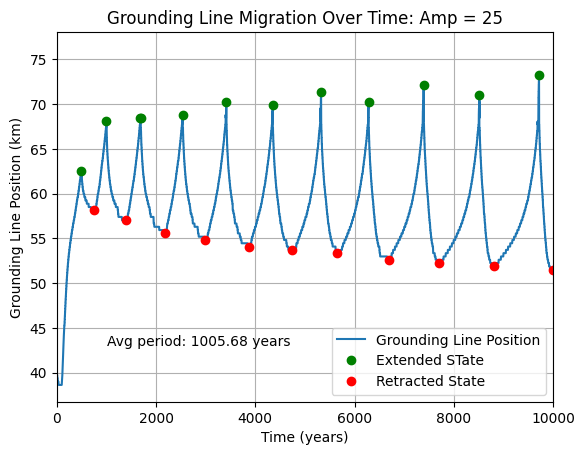

Mean cycle period: 1005.68 years
[ 507.82661258  681.70267669    4.91514088  849.15021232  881.02982757
  933.88584238  975.76003817  956.69199823 1112.22753825 1121.89367366
 1203.07344503 1314.38156987    3.89626837 1482.78615596 1721.70275592
 2220.73684576   10.19771309   12.63566142 3113.36453523]
Mean advance amplitude: 70.95 km
[62.54180602 68.06020067 68.42809365 68.42809365 68.79598662 70.26755853
 69.89966555 71.37123746 70.26755853 72.10702341 71.00334448 73.21070234
 70.63545151 71.73913043 73.21070234 73.94648829 70.26755853 72.84280936
 76.15384615 75.78595318]
Mean retreat amplitude: 55.61 km
[58.1270903  57.02341137 55.55183946 54.81605351 54.08026756 53.71237458
 53.34448161 52.60869565 52.24080268 51.8729097  51.50501672 68.42809365
 51.13712375 50.76923077 50.03344482 68.06020067 68.42809365 49.29765886]


In [210]:
amp_25_peaks, _ = find_peaks(GL_km_amp_25, prominence=2) 
amp_25_troughs, _ = find_peaks(-GL_km_amp_25, prominence=2)     
amp_25_periods = np.diff(np.array(time)[amp_25_peaks])
amp_25_GL_dists = GL_km_amp_25[amp_25_peaks]
amp_25_ret_dists = GL_km_amp_25[amp_25_troughs]

plt.plot(time, GL_km_amp_25, label='Grounding Line Position')
plt.plot(np.array(time)[amp_25_peaks], GL_km_amp_25[amp_25_peaks], 'go', label='Extended STate')
plt.plot(np.array(time)[amp_25_troughs], GL_km_amp_25[amp_25_troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(amp_25_periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlim(0,10000)

plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amp = 25")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(amp_25_periods):.2f} years")
print(amp_25_periods)

print(f"Mean advance amplitude: {np.mean(amp_25_GL_dists):.2f} km")
print(amp_25_GL_dists)

print(f"Mean retreat amplitude: {np.mean(amp_25_ret_dists):.2f} km")
print(amp_25_ret_dists)


## Grounding Line plotting - AMP 50

In [211]:
gl_run_title_50 = str("Grounding Line Evolution Over Time - Bump Amplitude = 50")
amp_50 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/AmpTests/Run3_amp50/DATA_Dictionary_2025_02_25__13_42_21.pkl.gz"
with gzip.open(amp_50, 'rb') as f:
    DATA_dict_amp50 = pickle.load(f)

In [212]:
bed_dict = DATA_dict_amp50['bed_dict']
base_dict = DATA_dict_amp50['base_dict']
surf_dict= DATA_dict_amp50 ['surf_dict']
sed_dict = DATA_dict_amp50['sed_dict']
H_dict = DATA_dict_amp50['H_dict']
us_dict = DATA_dict_amp50['us_dict']
ub_dict = DATA_dict_amp50['ub_dict']
Hs_dict = DATA_dict_amp50['Hs_dict']
GL_dict = DATA_dict_amp50['GL_dict']
Qs_dict = DATA_dict_amp50['Qs_dict']

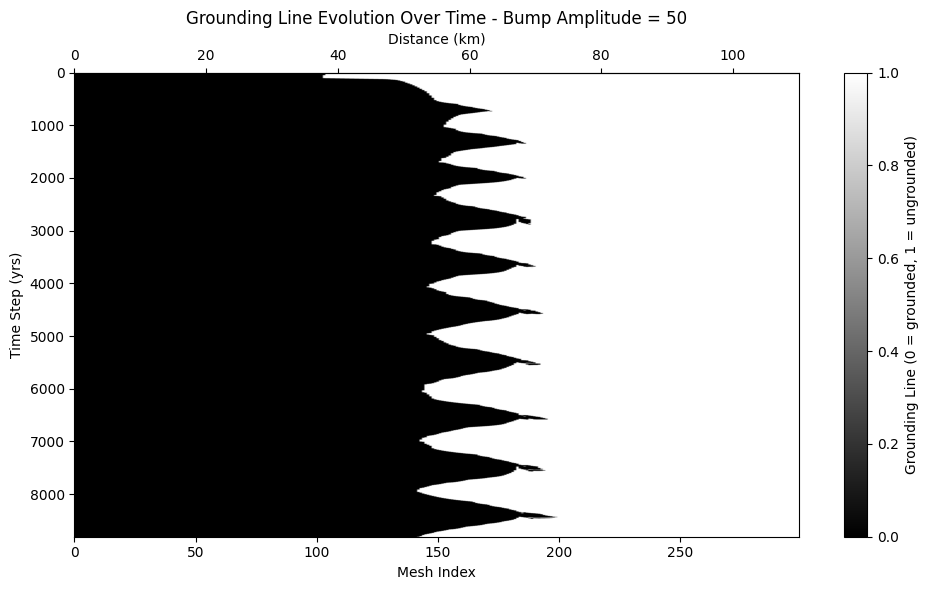

In [213]:
GL_dict = DATA_dict_amp50['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_50)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [214]:
gl_positions_amp_50 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amp_50.append(idx)

gl_positions_amp_50 = np.array(gl_positions_amp_50)
GL_km_amp_50 = mesh_index_to_km(gl_positions_amp_50)

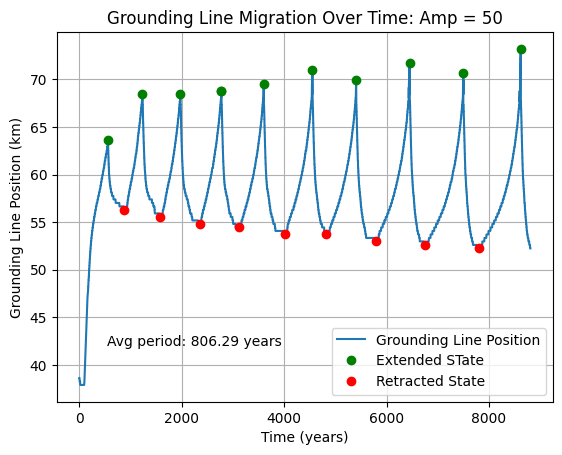

Mean cycle period: 806.29 years
[ 672.8499698   738.98773814  799.0538125     4.99395591  825.56284851
  952.59244111  853.46807999 1043.19361098 1050.50774827 1121.68511392]
Mean advance amplitude: 69.46 km
[63.64548495 68.42809365 68.42809365 68.79598662 68.79598662 69.53177258
 71.00334448 69.89966555 71.73913043 70.63545151 73.21070234]
Mean retreat amplitude: 54.04 km
[56.28762542 55.55183946 54.81605351 54.44816054 53.71237458 53.71237458
 52.97658863 52.60869565 52.24080268]


In [215]:
amp_50_peaks, _ = find_peaks(GL_km_amp_50, prominence=2) 
amp_50_troughs, _ = find_peaks(-GL_km_amp_50, prominence=2)     
amp_50_periods = np.diff(np.array(time)[amp_50_peaks])
amp_50_GL_dists = GL_km_amp_50[amp_50_peaks]
amp_50_ret_dists = GL_km_amp_50[amp_50_troughs]




plt.plot(time, GL_km_amp_50, label='Grounding Line Position')
plt.plot(np.array(time)[amp_50_peaks], GL_km_amp_50[amp_50_peaks], 'go', label='Extended STate')
plt.plot(np.array(time)[amp_50_troughs], GL_km_amp_50[amp_50_troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(amp_50_periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amp = 50")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(amp_50_periods):.2f} years")
print(amp_50_periods)

print(f"Mean advance amplitude: {np.mean(amp_50_GL_dists):.2f} km")
print(amp_50_GL_dists)\

print(f"Mean retreat amplitude: {np.mean(amp_50_ret_dists):.2f} km")
print(amp_50_ret_dists)

## Grounding Line plotting - AMP 75

In [216]:
gl_run_title_75 = str("Grounding Line Evolution Over Time - Bump Amplitude = 75")
amp_75 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/AmpTests/Run4_amp75/DATA_Dictionary_2025_02_25__16_21_51.pkl.gz"
with gzip.open(amp_75, 'rb') as f:
    DATA_dict_amp75 = pickle.load(f)

In [217]:
bed_dict = DATA_dict_amp75['bed_dict']
base_dict = DATA_dict_amp75['base_dict']
surf_dict= DATA_dict_amp75 ['surf_dict']
sed_dict = DATA_dict_amp75['sed_dict']
H_dict = DATA_dict_amp75['H_dict']
us_dict = DATA_dict_amp75['us_dict']
ub_dict = DATA_dict_amp75['ub_dict']
Hs_dict = DATA_dict_amp75['Hs_dict']
GL_dict = DATA_dict_amp75['GL_dict']
Qs_dict = DATA_dict_amp75['Qs_dict']

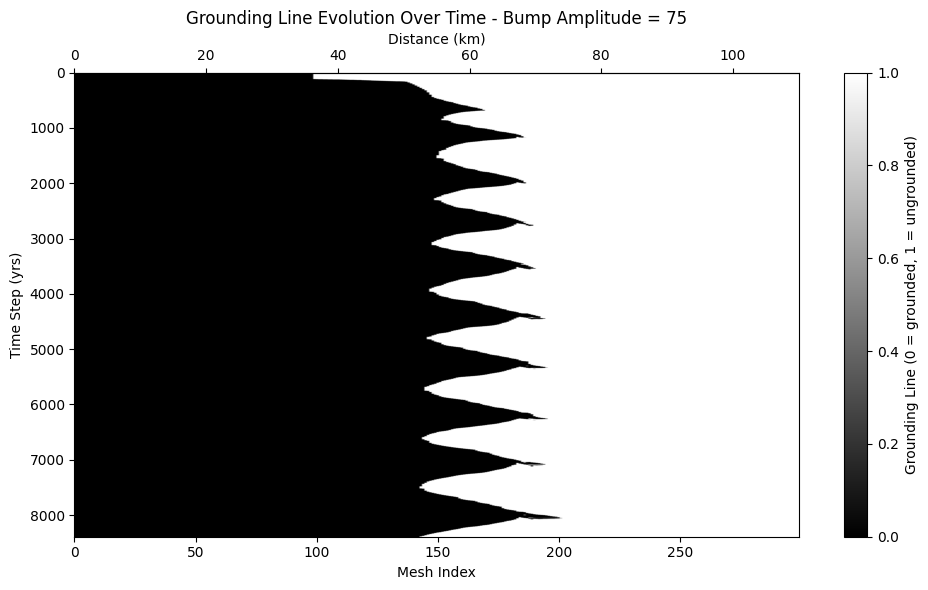

In [218]:
GL_dict = DATA_dict_amp75['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_75)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [219]:
gl_positions_amp_75 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amp_75.append(idx)

gl_positions_amp_75 = np.array(gl_positions_amp_75)
GL_km_amp_75 = mesh_index_to_km(gl_positions_amp_75)

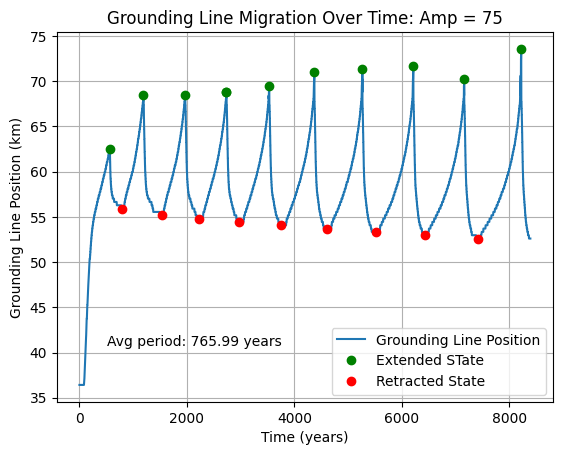

Mean cycle period: 765.99 years
[ 630.52949844  773.31105156  765.75987046    5.60588893  794.66005051
  840.07659106  893.72307621  948.33550154  946.00819064 1061.94026021]
Mean advance amplitude: 69.50 km
[62.54180602 68.42809365 68.42809365 68.79598662 68.79598662 69.53177258
 71.00334448 71.37123746 71.73913043 70.26755853 73.57859532]
Mean retreat amplitude: 54.12 km
[55.91973244 55.18394649 54.81605351 54.44816054 54.08026756 53.71237458
 53.34448161 52.97658863 52.60869565]


In [220]:
amp_75_peaks, _ = find_peaks(GL_km_amp_75, prominence=3) 
amp_75_troughs, _ = find_peaks(-GL_km_amp_75, prominence=3)     
amp_75_periods = np.diff(np.array(time)[amp_75_peaks])
amp_75_GL_dists = GL_km_amp_75[amp_75_peaks]
amp_75_ret_dists = GL_km_amp_75[amp_75_troughs]



plt.plot(time, GL_km_amp_75, label='Grounding Line Position')
plt.plot(np.array(time)[amp_75_peaks], GL_km_amp_75[amp_75_peaks], 'go', label='Extended STate')
plt.plot(np.array(time)[amp_75_troughs], GL_km_amp_75[amp_75_troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(amp_75_periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amp = 75")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(amp_75_periods):.2f} years")
print(amp_75_periods)

print(f"Mean advance amplitude: {np.mean(amp_75_GL_dists):.2f} km")
print(amp_75_GL_dists)

print(f"Mean retreat amplitude: {np.mean(amp_75_ret_dists):.2f} km")
print(amp_75_ret_dists)

## Grounding Line plotting - AMP 100

In [221]:
gl_run_title_100 = str("Grounding Line Evolution Over Time - Bump Amplitude = 100")
amp_100 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/AmpTests/Run5_amp100/DATA_Dictionary_2025_02_25__18_16_40.pkl.gz"
with gzip.open(amp_100, 'rb') as f:
    DATA_dict_amp100 = pickle.load(f)

In [222]:
bed_dict = DATA_dict_amp100['bed_dict']
base_dict = DATA_dict_amp100['base_dict']
surf_dict= DATA_dict_amp100 ['surf_dict']
sed_dict = DATA_dict_amp100['sed_dict']
H_dict = DATA_dict_amp100['H_dict']
us_dict = DATA_dict_amp100['us_dict']
ub_dict = DATA_dict_amp100['ub_dict']
Hs_dict = DATA_dict_amp100['Hs_dict']
GL_dict = DATA_dict_amp100['GL_dict']
Qs_dict = DATA_dict_amp100['Qs_dict']

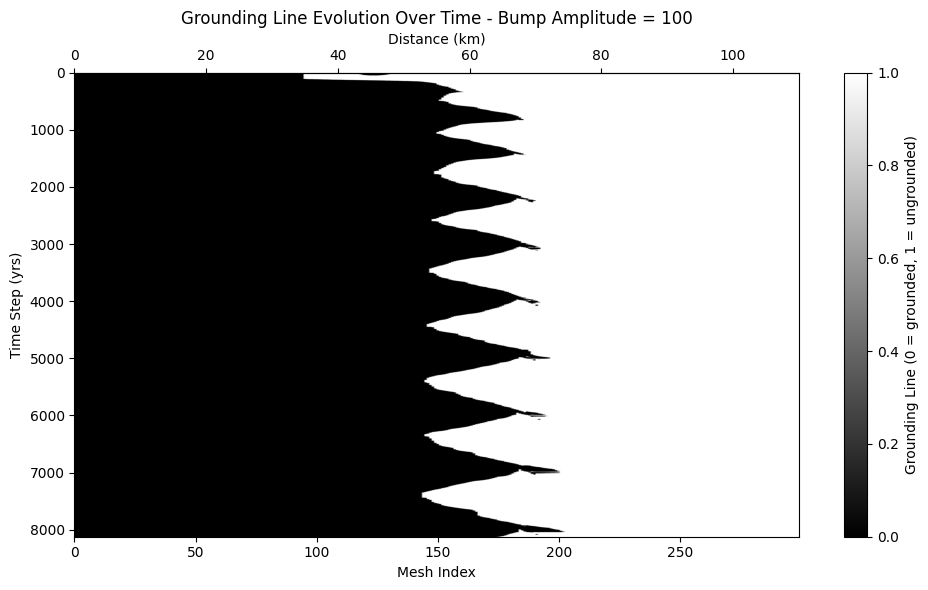

In [223]:
GL_dict = DATA_dict_amp100['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_100)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [224]:
gl_positions_amp_100 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amp_100.append(idx)

gl_positions_amp_100 = np.array(gl_positions_amp_100)
GL_km_amp_100 = mesh_index_to_km(gl_positions_amp_100)

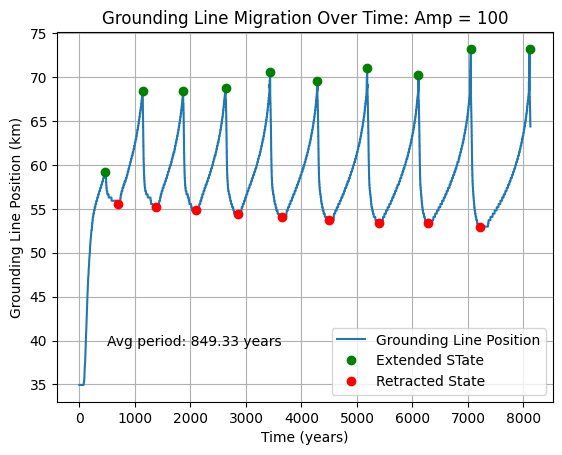

Mean cycle period: 849.33 years
[ 671.04104519  731.17664818  765.35723967  801.83053734  850.85569445
  897.86178343  923.5788195   943.37435896 1058.89407233]
Mean advance amplitude: 69.27 km
[59.23076923 68.42809365 68.42809365 68.79598662 70.63545151 69.53177258
 71.00334448 70.26755853 73.21070234 73.21070234]
Mean retreat amplitude: 54.16 km
[55.55183946 55.18394649 54.81605351 54.44816054 54.08026756 53.71237458
 53.34448161 53.34448161 52.97658863]


In [225]:
amp_100_peaks, _ = find_peaks(GL_km_amp_100, prominence=3) 
amp_100_troughs, _ = find_peaks(-GL_km_amp_100, prominence=3)     
amp_100_periods = np.diff(np.array(time)[amp_100_peaks])
amp_100_GL_dists = GL_km_amp_100[amp_100_peaks]
amp_100_ret_dists = GL_km_amp_100[amp_100_troughs]



plt.plot(time, GL_km_amp_100, label='Grounding Line Position')
plt.plot(np.array(time)[amp_100_peaks], GL_km_amp_100[amp_100_peaks], 'go', label='Extended STate')
plt.plot(np.array(time)[amp_100_troughs], GL_km_amp_100[amp_100_troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(amp_100_periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amp = 100")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(amp_100_periods):.2f} years")
print(amp_100_periods)

print(f"Mean advance amplitude: {np.mean(amp_100_GL_dists):.2f} km")
print(amp_100_GL_dists)

print(f"Mean retreat amplitude: {np.mean(amp_100_ret_dists):.2f} km")
print(amp_100_ret_dists)

## Grounding Line plotting - AMP 125

In [273]:
gl_run_title_125 = str("Grounding Line Evolution Over Time - Bump Amplitude = 125")
amp_125 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/AmpTests/Run6_amp125/DATA_Dictionary_2025_02_26__11_01_28.pkl.gz"
with gzip.open(amp_125, 'rb') as f:
    DATA_dict_amp125 = pickle.load(f)

In [274]:
bed_dict = DATA_dict_amp125['bed_dict']
base_dict = DATA_dict_amp125['base_dict']
surf_dict= DATA_dict_amp125 ['surf_dict']
sed_dict = DATA_dict_amp125['sed_dict']
H_dict = DATA_dict_amp125['H_dict']
us_dict = DATA_dict_amp125['us_dict']
ub_dict = DATA_dict_amp125['ub_dict']
Hs_dict = DATA_dict_amp125['Hs_dict']
GL_dict = DATA_dict_amp125['GL_dict']
Qs_dict = DATA_dict_amp125['Qs_dict']

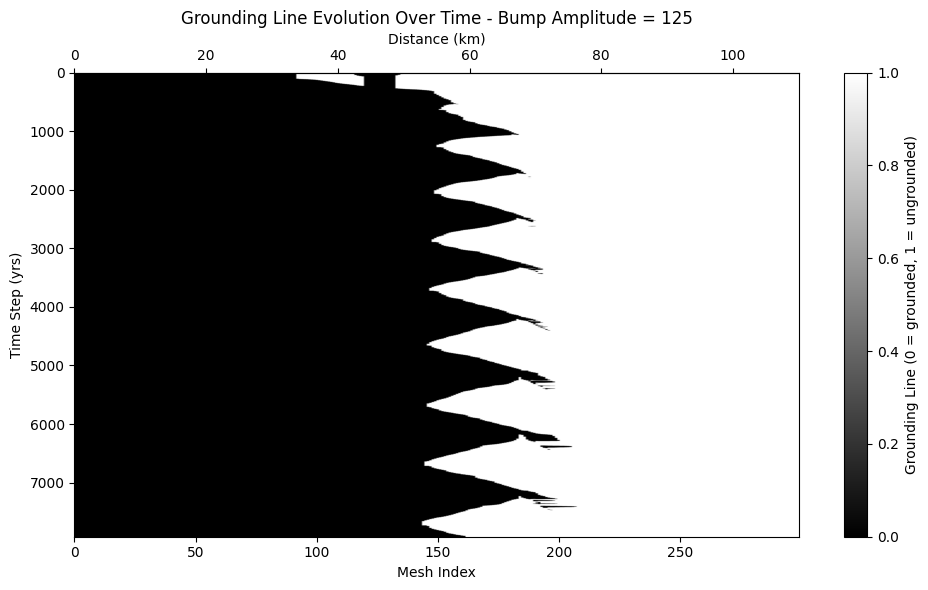

In [275]:
GL_dict = DATA_dict_amp125['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_125)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [276]:
gl_positions_amp_125 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amp_125.append(idx)

gl_positions_amp_125 = np.array(gl_positions_amp_125)
GL_km_amp_125 = mesh_index_to_km(gl_positions_amp_125)

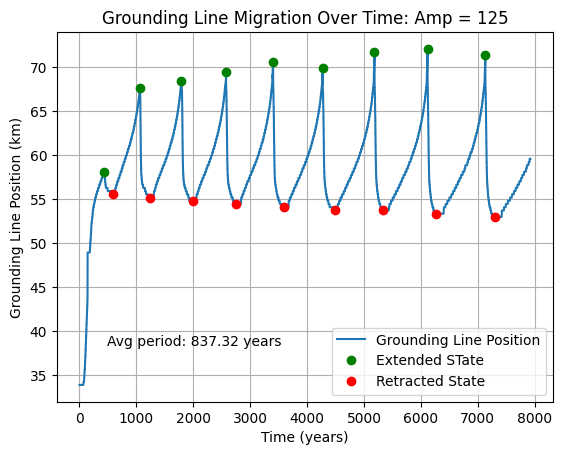

Mean cycle period: 837.32 years
[ 632.03922359  727.22351356  783.89428684  826.45376082  871.58294504
  910.67884279  931.71555799 1015.00985145]
Mean advance amplitude: 68.84 km
[58.1270903  67.69230769 68.42809365 69.53177258 70.63545151 69.89966555
 71.73913043 72.10702341 71.37123746]
Mean retreat amplitude: 54.20 km
[55.55183946 55.18394649 54.81605351 54.44816054 54.08026756 53.71237458
 53.71237458 53.34448161 52.97658863]


In [277]:
amp_125_peaks, _ = find_peaks(GL_km_amp_125, prominence=2) 
amp_125_troughs, _ = find_peaks(-GL_km_amp_125, prominence=2)     
amp_125_periods = np.diff(np.array(time)[amp_125_peaks])
amp_125_GL_dists = GL_km_amp_125[amp_125_peaks]
amp_125_ret_dists = GL_km_amp_125[amp_125_troughs]



plt.plot(time, GL_km_amp_125, label='Grounding Line Position')
plt.plot(np.array(time)[amp_125_peaks], GL_km_amp_125[amp_125_peaks], 'go', label='Extended STate')
plt.plot(np.array(time)[amp_125_troughs], GL_km_amp_125[amp_125_troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(amp_125_periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amp = 125")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(amp_125_periods):.2f} years")
print(amp_125_periods)

print(f"Mean advance amplitude: {np.mean(amp_125_GL_dists):.2f} km")
print(amp_125_GL_dists)

print(f"Mean retreat amplitude: {np.mean(amp_125_ret_dists):.2f} km")
print(amp_125_ret_dists)

## Grounding Line plotting - AMP 150

In [231]:
gl_run_title_150 = str("Grounding Line Evolution Over Time - Bump Amplitude = 150")
amp_150 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/AmpTests/Run7_amp150/DATA_Dictionary_2025_02_26__12_28_48.pkl.gz"
with gzip.open(amp_150, 'rb') as f:
    DATA_dict_amp150 = pickle.load(f)

In [232]:
bed_dict = DATA_dict_amp150['bed_dict']
base_dict = DATA_dict_amp150['base_dict']
surf_dict= DATA_dict_amp150 ['surf_dict']
sed_dict = DATA_dict_amp150['sed_dict']
H_dict = DATA_dict_amp150['H_dict']
us_dict = DATA_dict_amp150['us_dict']
ub_dict = DATA_dict_amp150['ub_dict']
Hs_dict = DATA_dict_amp150['Hs_dict']
GL_dict = DATA_dict_amp150['GL_dict']
Qs_dict = DATA_dict_amp150['Qs_dict']

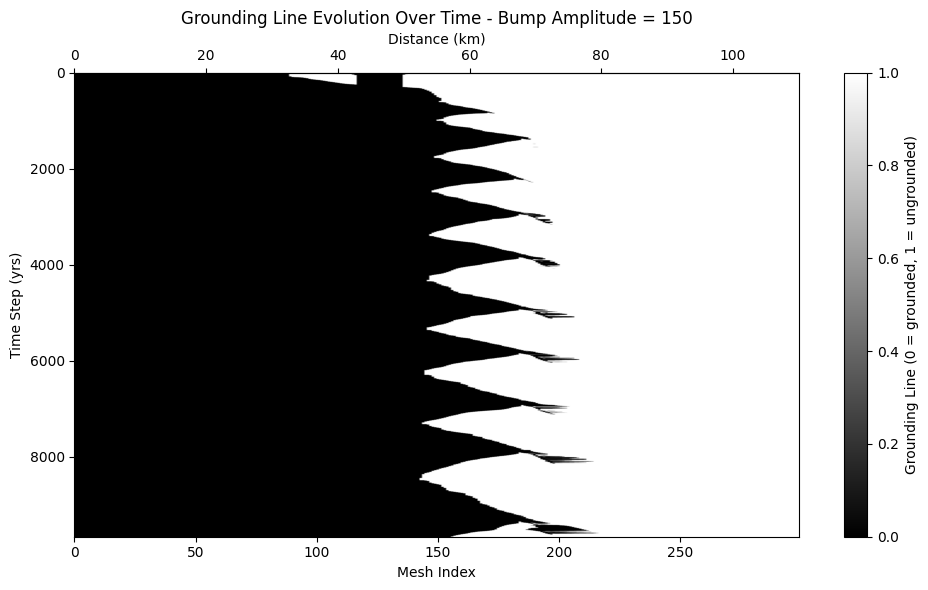

In [233]:
GL_dict = DATA_dict_amp150['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_150)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [234]:
gl_positions_amp_150 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amp_150.append(idx)

gl_positions_amp_150 = np.array(gl_positions_amp_150)
GL_km_amp_150 = mesh_index_to_km(gl_positions_amp_150)

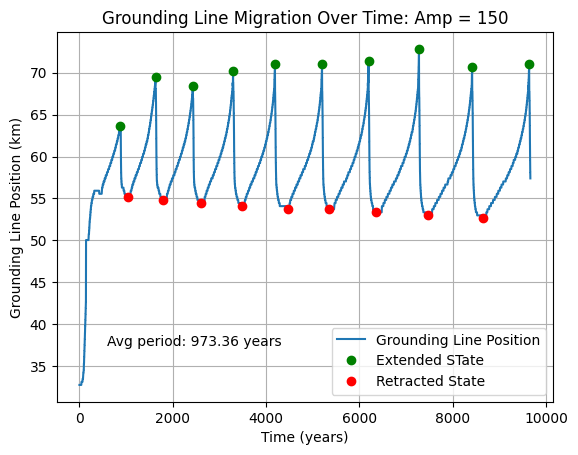

Mean cycle period: 973.36 years
[ 755.18323726  800.01259209  860.60194255  898.36873348 1008.4138963
  997.40090309 1079.74945845 1139.02889932 1221.44066803]
Mean advance amplitude: 69.97 km
[63.64548495 69.53177258 68.42809365 70.26755853 71.00334448 71.00334448
 71.37123746 72.84280936 70.63545151 71.00334448]
Mean retreat amplitude: 53.88 km
[55.18394649 54.81605351 54.44816054 54.08026756 53.71237458 53.71237458
 53.34448161 52.97658863 52.60869565]


In [235]:
amp_150_peaks, _ = find_peaks(GL_km_amp_150, prominence=3) 
amp_150_troughs, _ = find_peaks(-GL_km_amp_150, prominence=3)     
amp_150_periods = np.diff(np.array(time)[amp_150_peaks])
amp_150_GL_dists = GL_km_amp_150[amp_150_peaks]
amp_150_ret_dists = GL_km_amp_150[amp_150_troughs]



plt.plot(time, GL_km_amp_150, label='Grounding Line Position')
plt.plot(np.array(time)[amp_150_peaks], GL_km_amp_150[amp_150_peaks], 'go', label='Extended STate')
plt.plot(np.array(time)[amp_150_troughs], GL_km_amp_150[amp_150_troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(amp_150_periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amp = 150")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(amp_150_periods):.2f} years")
print(amp_150_periods)

print(f"Mean advance amplitude: {np.mean(amp_150_GL_dists):.2f} km")
print(amp_150_GL_dists)

print(f"Mean retreat amplitude: {np.mean(amp_150_ret_dists):.2f} km")
print(amp_150_ret_dists)

## Grounding Line plotting - AMP 175

In [236]:
gl_run_title_175 = str("Grounding Line Evolution Over Time - Bump Amplitude = 175")
amp_175 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/AmpTests/Run8_amp175/DATA_Dictionary_2025_02_26__13_51_53.pkl.gz"
with gzip.open(amp_175, 'rb') as f:
    DATA_dict_amp175 = pickle.load(f)

In [237]:
bed_dict = DATA_dict_amp175['bed_dict']
base_dict = DATA_dict_amp175['base_dict']
surf_dict= DATA_dict_amp175 ['surf_dict']
sed_dict = DATA_dict_amp175['sed_dict']
H_dict = DATA_dict_amp175['H_dict']
us_dict = DATA_dict_amp175['us_dict']
ub_dict = DATA_dict_amp175['ub_dict']
Hs_dict = DATA_dict_amp175['Hs_dict']
GL_dict = DATA_dict_amp175['GL_dict']
Qs_dict = DATA_dict_amp175['Qs_dict']

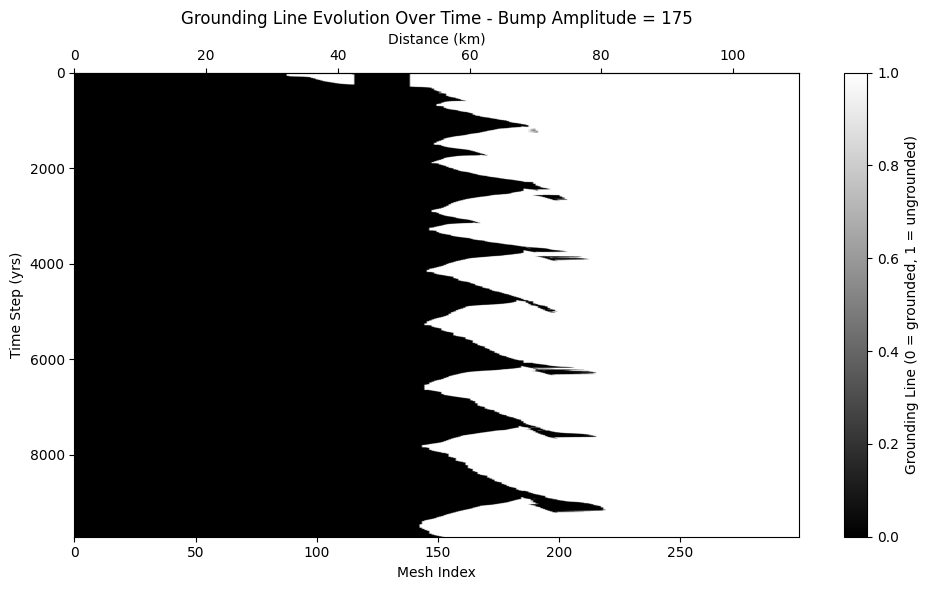

In [238]:
GL_dict = DATA_dict_amp175['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_175)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [239]:
gl_positions_amp_175 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amp_175.append(idx)

gl_positions_amp_175 = np.array(gl_positions_amp_175)
GL_km_amp_175 = mesh_index_to_km(gl_positions_amp_175)

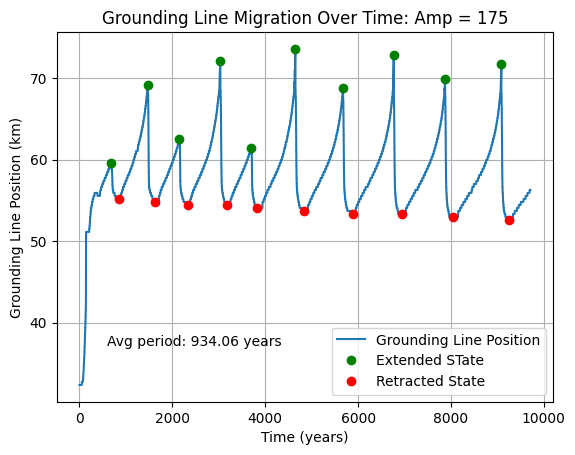

Mean cycle period: 934.06 years
[ 791.10652888  681.39578817  880.64031954  663.84079233  952.01561671
 1027.81000633 1091.70629224 1104.7298851  1213.25048011]
Mean advance amplitude: 68.17 km
[59.59866221 69.1638796  62.54180602 72.10702341 61.43812709 73.57859532
 68.79598662 72.84280936 69.89966555 71.73913043]
Mean retreat amplitude: 53.90 km
[55.18394649 54.81605351 54.44816054 54.44816054 54.08026756 53.71237458
 53.34448161 53.34448161 52.97658863 52.60869565]


In [240]:
amp_175_peaks, _ = find_peaks(GL_km_amp_175, prominence=3) 
amp_175_troughs, _ = find_peaks(-GL_km_amp_175, prominence=3)     
amp_175_periods = np.diff(np.array(time)[amp_175_peaks])
amp_175_GL_dists = GL_km_amp_175[amp_175_peaks]
amp_175_ret_dists = GL_km_amp_175[amp_175_troughs]



plt.plot(time, GL_km_amp_175, label='Grounding Line Position')
plt.plot(np.array(time)[amp_175_peaks], GL_km_amp_175[amp_175_peaks], 'go', label='Extended STate')
plt.plot(np.array(time)[amp_175_troughs], GL_km_amp_175[amp_175_troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(amp_175_periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amp = 175")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(amp_175_periods):.2f} years")
print(amp_175_periods)

print(f"Mean advance amplitude: {np.mean(amp_175_GL_dists):.2f} km")
print(amp_175_GL_dists)

print(f"Mean retreat amplitude: {np.mean(amp_175_ret_dists):.2f} km")
print(amp_175_ret_dists)

## Grounding Line plotting - AMP 200

In [241]:
gl_run_title_200 = str("Grounding Line Evolution Over Time - Bump Amplitude = 200")
amp_200 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/AmpTests/Run9_amp200/DATA_Dictionary_2025_02_26__15_25_45.pkl.gz"
with gzip.open(amp_200, 'rb') as f:
    DATA_dict_amp200 = pickle.load(f)

In [242]:
bed_dict = DATA_dict_amp200['bed_dict']
base_dict = DATA_dict_amp200['base_dict']
surf_dict= DATA_dict_amp200 ['surf_dict']
sed_dict = DATA_dict_amp200['sed_dict']
H_dict = DATA_dict_amp200['H_dict']
us_dict = DATA_dict_amp200['us_dict']
ub_dict = DATA_dict_amp200['ub_dict']
Hs_dict = DATA_dict_amp200['Hs_dict']
GL_dict = DATA_dict_amp200['GL_dict']
Qs_dict = DATA_dict_amp200['Qs_dict']

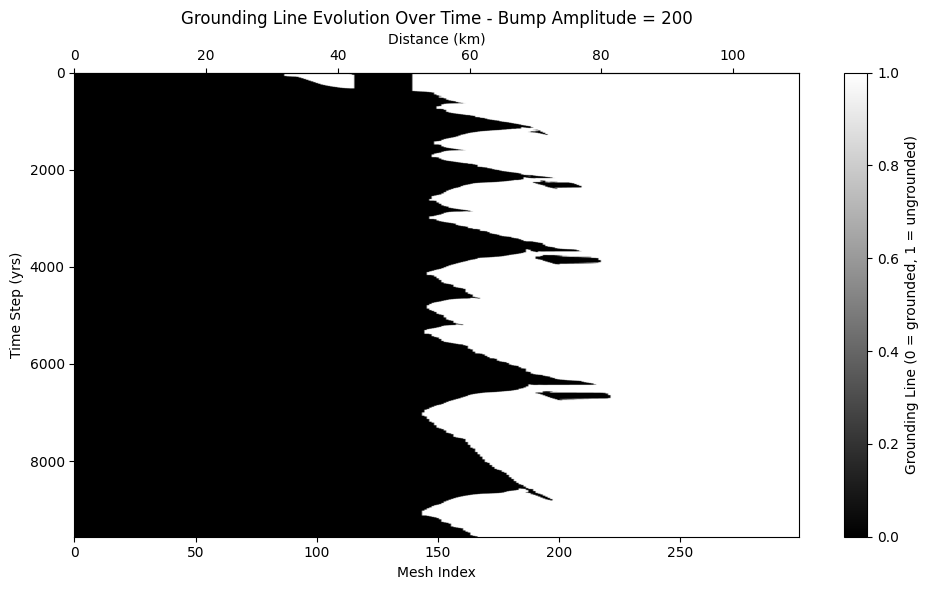

In [243]:
GL_dict = DATA_dict_amp200['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_200)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [244]:
gl_positions_amp_200 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amp_200.append(idx)

gl_positions_amp_200 = np.array(gl_positions_amp_200)
GL_km_amp_200 = mesh_index_to_km(gl_positions_amp_200)
# gl_smooth_225 = savgol_filter(GL_km_amp_200, window_length=101, polyorder=4)
# gl_smooth_225= pd.Series(GL_km_amp_200).rolling(window=0, center=True).mean().to_numpy()



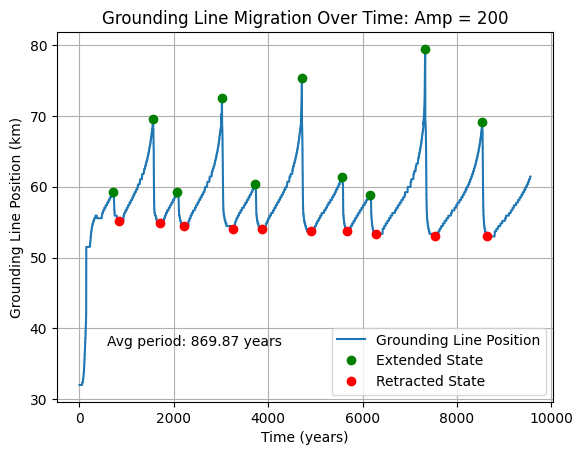

Mean cycle period: 869.87 years
[ 849.90857002  515.94208288  945.00887413  703.18055763  990.99865353
  853.25251486  581.83536071 1178.87276516 1209.83958451]
Mean advance amplitude: 66.52 km
[59.23076923 69.53177258 59.23076923 72.47491639 60.33444816 75.4180602
 61.43812709 58.86287625 79.46488294 69.1638796 ]
Mean retreat amplitude: 53.93 km
[55.18394649 54.81605351 54.44816054 54.08026756 54.08026756 53.71237458
 53.71237458 53.34448161 52.97658863 52.97658863]


In [245]:
amp_200_peaks, _ = find_peaks(GL_km_amp_200, prominence=2)  # tweak prominence if needed
amp_200_troughs, _ = find_peaks(-GL_km_amp_200, prominence=3)     
amp_200_periods = np.diff(np.array(time)[amp_200_peaks])
amp_200_GL_dists = GL_km_amp_200[amp_200_peaks]
amp_200_ret_dists = GL_km_amp_200[amp_200_troughs]



plt.plot(time, GL_km_amp_200, label='Grounding Line Position')
plt.plot(np.array(time)[amp_200_peaks], GL_km_amp_200[amp_200_peaks], 'go', label='Extended State')
plt.plot(np.array(time)[amp_200_troughs], GL_km_amp_200[amp_200_troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(amp_200_periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amp = 200")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(amp_200_periods):.2f} years")
print(amp_200_periods)

print(f"Mean advance amplitude: {np.mean(amp_200_GL_dists):.2f} km")
print(amp_200_GL_dists)

print(f"Mean retreat amplitude: {np.mean(amp_200_ret_dists):.2f} km")
print(amp_200_ret_dists)

## Grounding Line plotting - AMP 225

In [246]:
gl_run_title_225 = str("Grounding Line Evolution Over Time - Bump Amplitude = 225")
amp_225 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/AmpTests/Run10_amp225/DATA_Dictionary_2025_02_27__13_02_57.pkl.gz"
with gzip.open(amp_225, 'rb') as f:
    DATA_dict_amp225 = pickle.load(f)

In [247]:
bed_dict = DATA_dict_amp225['bed_dict']
base_dict = DATA_dict_amp225['base_dict']
surf_dict= DATA_dict_amp225 ['surf_dict']
sed_dict = DATA_dict_amp225['sed_dict']
H_dict = DATA_dict_amp225['H_dict']
us_dict = DATA_dict_amp225['us_dict']
ub_dict = DATA_dict_amp225['ub_dict']
Hs_dict = DATA_dict_amp225['Hs_dict']
GL_dict = DATA_dict_amp225['GL_dict']
Qs_dict = DATA_dict_amp225['Qs_dict']

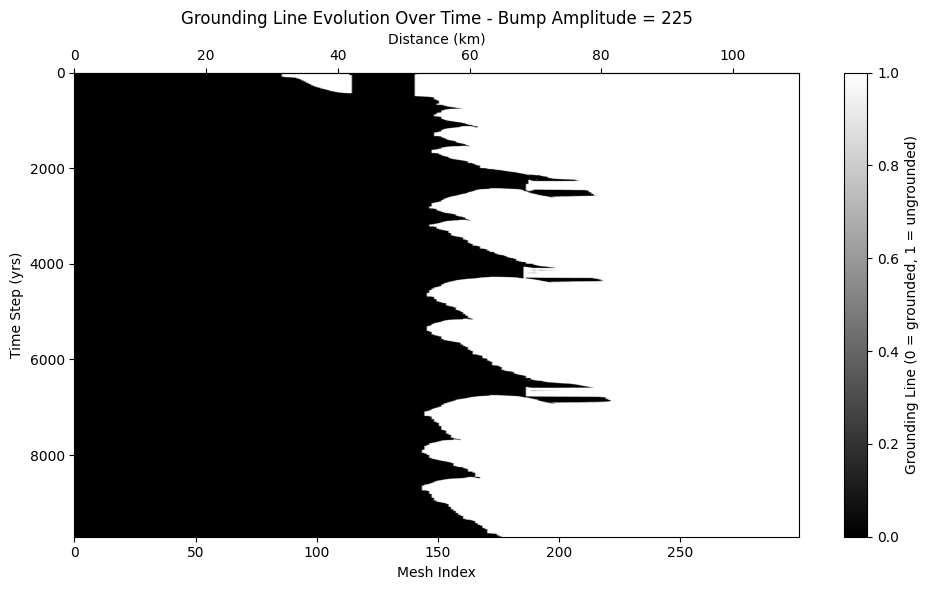

In [248]:
GL_dict = DATA_dict_amp225['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_225)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [249]:
gl_positions_amp_225 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amp_225.append(idx)

gl_positions_amp_225 = np.array(gl_positions_amp_225)
GL_km_amp_225= mesh_index_to_km(gl_positions_amp_225)

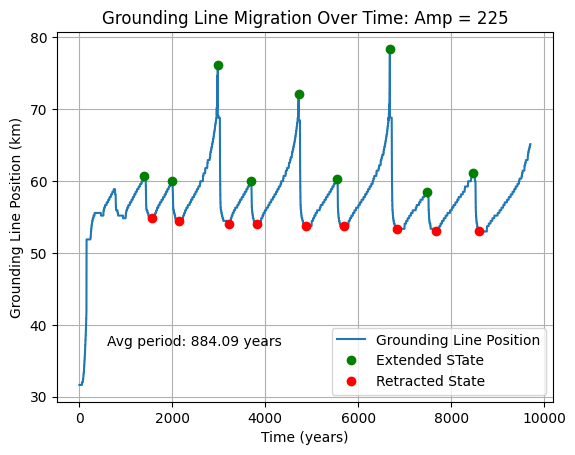

Mean cycle period: 884.09 years
[ 590.22638857  989.83041295  710.07454359 1031.53928721  820.51291604
 1142.58350289  800.48400101  987.49773492]
Mean advance amplitude: 65.24 km
[60.70234114 59.96655518 76.15384615 59.96655518 72.10702341 60.33444816
 78.36120401 58.49498328 61.07023411]
Mean retreat amplitude: 53.79 km
[54.81605351 54.44816054 54.08026756 54.08026756 53.71237458 53.71237458
 53.34448161 52.97658863 52.97658863]


In [250]:
amp_225_peaks, _ = find_peaks(GL_km_amp_225, prominence=4.5) 
amp_225_troughs, _ = find_peaks(-GL_km_amp_225, prominence=4.5)     
amp_225_periods = np.diff(np.array(time)[amp_225_peaks])
amp_225_GL_dists = GL_km_amp_225[amp_225_peaks]
amp_225_ret_dists = GL_km_amp_225[amp_225_troughs]



plt.plot(time, GL_km_amp_225, label='Grounding Line Position')
plt.plot(np.array(time)[amp_225_peaks], GL_km_amp_225[amp_225_peaks], 'go', label='Extended STate')
plt.plot(np.array(time)[amp_225_troughs], GL_km_amp_225[amp_225_troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(amp_225_periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amp = 225")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(amp_225_periods):.2f} years")
print(amp_225_periods)

print(f"Mean advance amplitude: {np.mean(amp_225_GL_dists):.2f} km")
print(amp_225_GL_dists)

print(f"Mean retreat amplitude: {np.mean(amp_225_ret_dists):.2f} km")
print(amp_225_ret_dists)

## Grounding Line plotting - AMP 250

In [251]:
gl_run_title_250 = str("Grounding Line Evolution Over Time - Bump Amplitude = 250")
amp_250 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/AmpTests/Run11_amp250/DATA_Dictionary_2025_02_27__15_04_36.pkl.gz"
with gzip.open(amp_250, 'rb') as f:
    DATA_dict_amp250 = pickle.load(f)

In [252]:
bed_dict = DATA_dict_amp250['bed_dict']
base_dict = DATA_dict_amp250['base_dict']
surf_dict= DATA_dict_amp250 ['surf_dict']
sed_dict = DATA_dict_amp250['sed_dict']
H_dict = DATA_dict_amp250['H_dict']
us_dict = DATA_dict_amp250['us_dict']
ub_dict = DATA_dict_amp250['ub_dict']
Hs_dict = DATA_dict_amp250['Hs_dict']
GL_dict = DATA_dict_amp250['GL_dict']
Qs_dict = DATA_dict_amp250['Qs_dict']

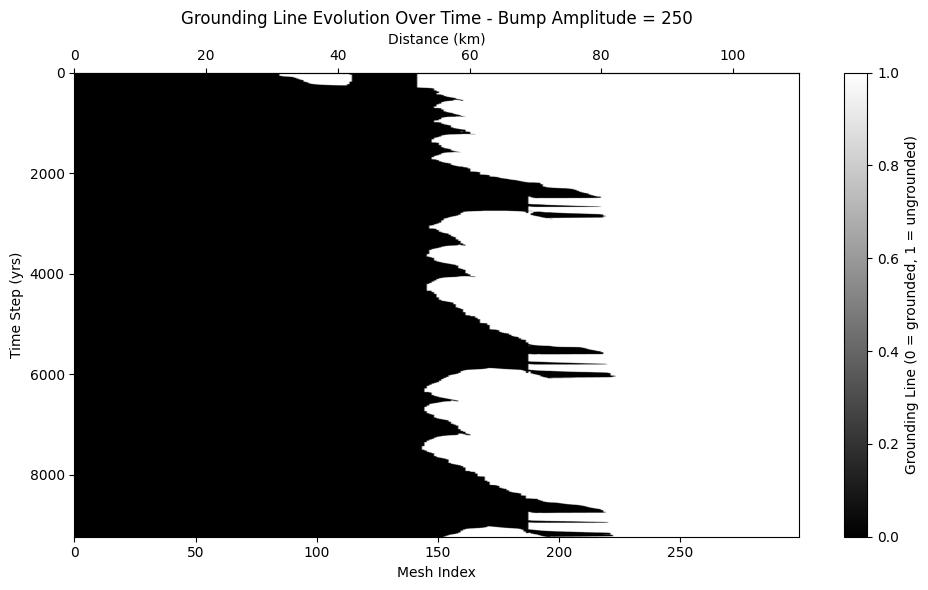

In [253]:
GL_dict = DATA_dict_amp250['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_250)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [254]:
gl_positions_amp_250 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amp_250.append(idx)

gl_positions_amp_250 = np.array(gl_positions_amp_250)
GL_km_amp_250 = mesh_index_to_km(gl_positions_amp_250)

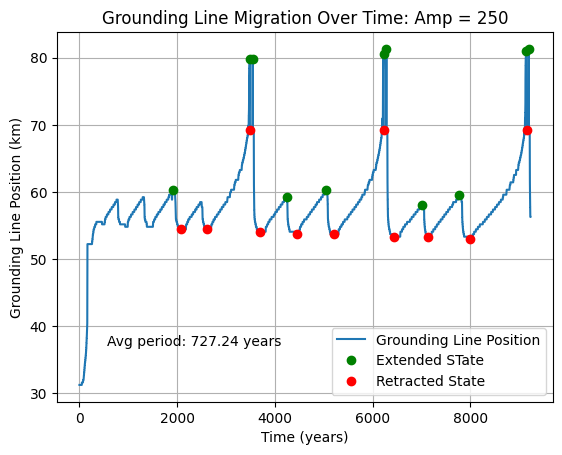

Mean cycle period: 727.24 years
[1566.30565223   59.22544963  698.23751679  795.75658027 1184.06358405
   57.58415209  734.60547944  760.33390806 1363.66230243   52.60446767]
Mean advance amplitude: 71.04 km
[60.33444816 79.83277592 79.83277592 59.23076923 60.33444816 80.56856187
 81.30434783 58.1270903  59.59866221 80.93645485 81.30434783]
Mean retreat amplitude: 57.96 km
[54.44816054 54.44816054 69.1638796  54.08026756 53.71237458 53.71237458
 69.1638796  53.34448161 53.34448161 52.97658863 69.1638796 ]


In [255]:
amp_250_peaks, _ = find_peaks(GL_km_amp_250, prominence=4.5) 
amp_250_troughs, _ = find_peaks(-GL_km_amp_250, prominence=4.5)     
amp_250_periods = np.diff(np.array(time)[amp_250_peaks])
amp_250_GL_dists = GL_km_amp_250[amp_250_peaks]
amp_225_ret_dists = GL_km_amp_250[amp_250_troughs]



plt.plot(time, GL_km_amp_250, label='Grounding Line Position')
plt.plot(np.array(time)[amp_250_peaks], GL_km_amp_250[amp_250_peaks], 'go', label='Extended STate')
plt.plot(np.array(time)[amp_250_troughs], GL_km_amp_250[amp_250_troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(amp_250_periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amp = 250")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(amp_250_periods):.2f} years")
print(amp_250_periods)

print(f"Mean advance amplitude: {np.mean(amp_250_GL_dists):.2f} km")
print(amp_250_GL_dists)

print(f"Mean retreat amplitude: {np.mean(amp_225_ret_dists):.2f} km")
print(amp_225_ret_dists)

## Grounding Line plotting - AMP 275

In [256]:
gl_run_title_275 = str("Grounding Line Evolution Over Time - Bump Amplitude = 275")
amp_275 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/AmpTests/Run12_amp275/DATA_Dictionary_2025_02_28__12_47_52.pkl.gz"
with gzip.open(amp_275, 'rb') as f:
    DATA_dict_amp275 = pickle.load(f)

In [257]:
bed_dict = DATA_dict_amp275['bed_dict']
base_dict = DATA_dict_amp275['base_dict']
surf_dict= DATA_dict_amp275 ['surf_dict']
sed_dict = DATA_dict_amp275['sed_dict']
H_dict = DATA_dict_amp275['H_dict']
us_dict = DATA_dict_amp275['us_dict']
ub_dict = DATA_dict_amp275['ub_dict']
Hs_dict = DATA_dict_amp275['Hs_dict']
GL_dict = DATA_dict_amp275['GL_dict']
Qs_dict = DATA_dict_amp275['Qs_dict']

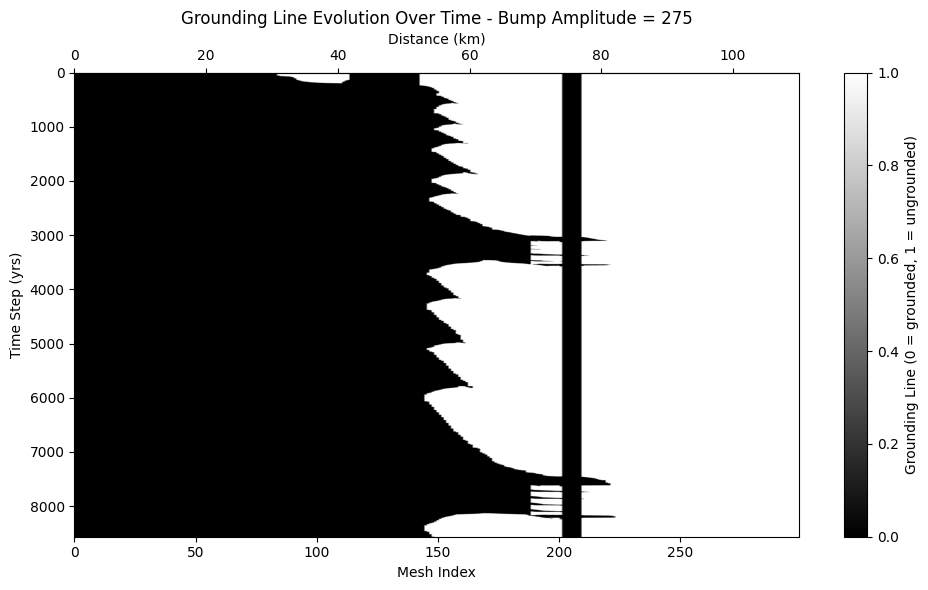

In [258]:
GL_dict = DATA_dict_amp275['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_275)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

## Grounding Line plotting - AMP 300

In [259]:
gl_run_title_300 = str("Grounding Line Evolution Over Time - Bump Amplitude = 300")
amp_300 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/AmpTests/Run13_amp300/DATA_Dictionary_2025_03_01__17_54_50.pkl.gz"
with gzip.open(amp_300, 'rb') as f:
    DATA_dict_amp300 = pickle.load(f)

In [260]:
bed_dict = DATA_dict_amp300['bed_dict']
base_dict = DATA_dict_amp300['base_dict']
surf_dict= DATA_dict_amp300 ['surf_dict']
sed_dict = DATA_dict_amp300['sed_dict']
H_dict = DATA_dict_amp300['H_dict']
us_dict = DATA_dict_amp300['us_dict']
ub_dict = DATA_dict_amp300['ub_dict']
Hs_dict = DATA_dict_amp300['Hs_dict']
GL_dict = DATA_dict_amp300['GL_dict']
Qs_dict = DATA_dict_amp300['Qs_dict']

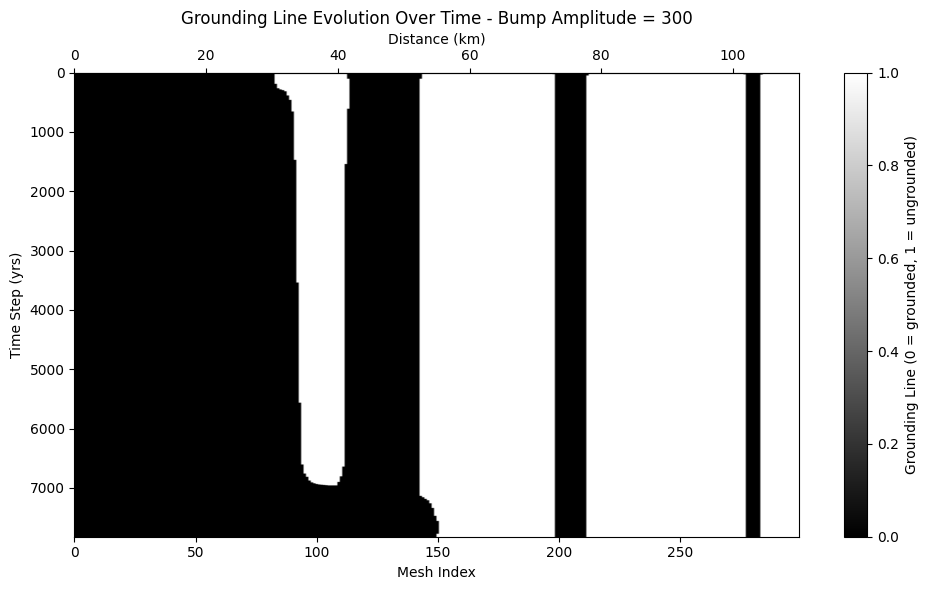

In [261]:
GL_dict = DATA_dict_amp300['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_300)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

# Relationship Plots

Number of Cycles in 10,000 years

In [262]:
## Bedrock Bump Amplitude ##
title_amp_cycles = str("Number of Cycles Produced  VS Bedrock Bump Amplitude")
AMPs = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275])
AMP_cycles = np.array([11, 11, 11, 11, 11, 11, 10, 10, 11, 11, 11, 11])
AMP_coeff = np.polyfit(AMPs,AMP_cycles, 1)
p_AMP = np.poly1d(AMP_coeff)
AMP_y_trend = p_AMP(AMPs)
R_2_AMP =r2_score(AMP_cycles,p_AMP(AMPs))


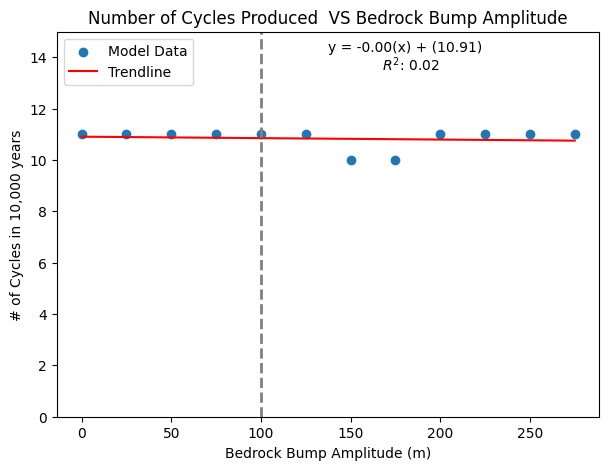

In [263]:
fig, ax1 = plt.subplots(figsize=(7,5))

plt.scatter(AMPs, AMP_cycles, label = 'Model Data')
plt.title(title_amp_cycles)
plt.plot(AMPs, AMP_y_trend, color='red', label='Trendline')
plt.text(0.6, 0.9, f'$R^2$: {R_2_AMP:.2f}', transform=plt.gca().transAxes)
plt.text(0.5, 0.95, f'y = {AMP_coeff[0]:.2f}(x) + ({AMP_coeff[1]:.2f})', transform=plt.gca().transAxes)
plt.axvline(x=100, color='gray', linestyle='--', linewidth=2)
plt.ylim(0,15)
plt.xlabel("Bedrock Bump Amplitude (m)")
plt.ylabel("# of Cycles in 10,000 years")
plt.legend()
# plt.xticks(np.arange(0, 2, 0.2)) 

# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/Amplitude/Relationship_Plots/#ofCycles_Amp.svg", format ="svg", bbox_inches='tight')


### Box and Whisker Plots

Variations in Cycle Period 

In [264]:
AMPs = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225])
Period_list = [amp_0_periods, amp_25_periods, amp_50_periods, amp_75_periods, amp_100_periods, amp_125_periods, amp_150_periods, amp_175_periods, amp_200_periods, amp_225_periods]


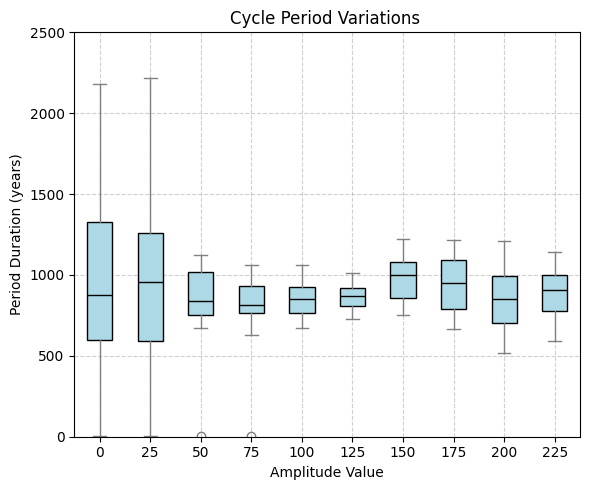

In [265]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(Period_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Cycle Period Variations ")
ax.set_ylabel("Period Duration (years)")
ax.set_xlabel("Amplitude Value")
ax.set_xticks(np.arange(1, len(AMPs) + 1))
ax.set_xticklabels(AMPs)
ax.set_ylim(0,2500)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/Amplitude/Relationship_Plots/PeriodVariation_Amp.svg", format ="svg", bbox_inches='tight')

Variations in GL Extent - Advance 

In [266]:
AMPs = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200])
ExtPos_list = [amp_0_adv_dists, amp_25_GL_dists, amp_50_GL_dists, amp_75_GL_dists, amp_100_GL_dists, amp_125_GL_dists, amp_150_GL_dists, amp_175_GL_dists, amp_200_GL_dists]


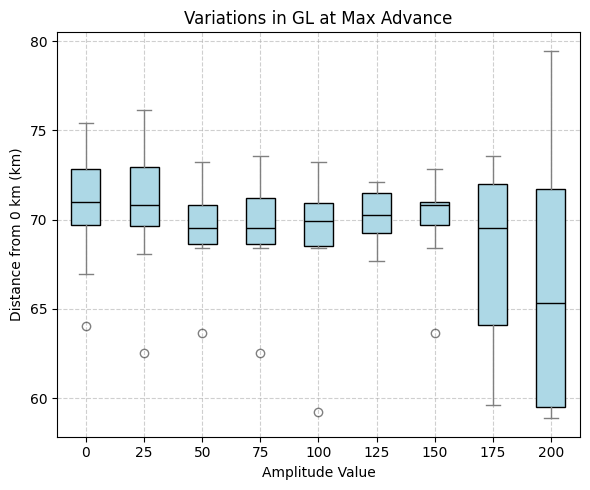

In [267]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(ExtPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Variations in GL at Max Advance")
ax.set_ylabel("Distance from 0 km (km)")
ax.set_xlabel("Amplitude Value")
ax.set_xticks(np.arange(1, len(AMPs) + 1))
ax.set_xticklabels(AMPs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Variations in GL Extent - Retreat 

In [268]:
AMPs = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200])
RetPos_list = [amp_0_ret_dists, amp_25_ret_dists, amp_50_ret_dists, amp_75_ret_dists, amp_100_ret_dists, amp_125_ret_dists, amp_150_ret_dists,  amp_175_ret_dists, amp_200_ret_dists]


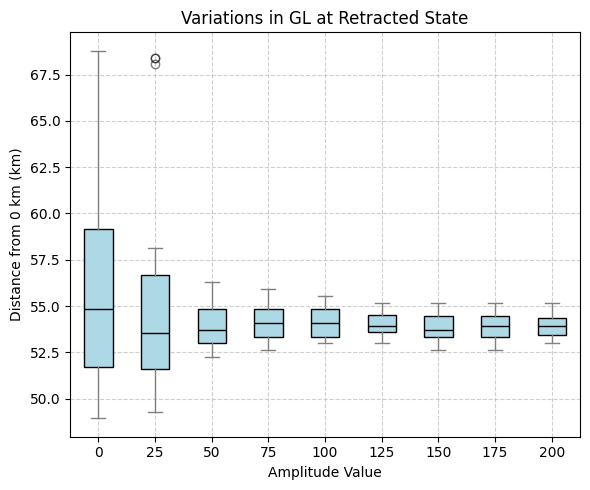

In [269]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(RetPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Variations in GL at Retracted State")
ax.set_ylabel("Distance from 0 km (km)")
ax.set_xlabel("Amplitude Value")
ax.set_xticks(np.arange(1, len(AMPs) + 1))
ax.set_xticklabels(AMPs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

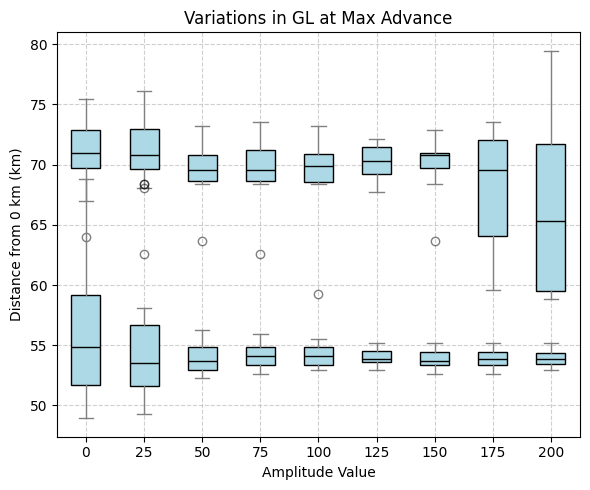

In [270]:
fig, ax = plt.subplots(figsize=(6, 5))

B1 = ax.boxplot(ExtPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

B2 = ax.boxplot(RetPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Variations in GL at Max Advance")
ax.set_ylabel("Distance from 0 km (km)")
ax.set_xlabel("Amplitude Value")
ax.set_xticks(np.arange(1, len(AMPs) + 1))
ax.set_xticklabels(AMPs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

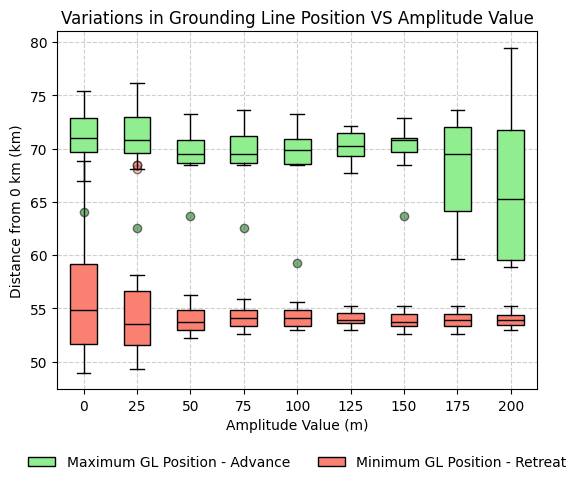

In [271]:
fig, ax = plt.subplots(figsize=(6, 5))

D2 = ax.boxplot(RetPos_list, patch_artist=True,
           boxprops=dict(facecolor='salmon'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           flierprops=dict(marker='o', markerfacecolor='salmon', alpha=0.5))

D1 = ax.boxplot(ExtPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightgreen'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           flierprops=dict(marker='o', markerfacecolor='darkgreen', alpha=0.5))

ax.set_title("Variations in Grounding Line Position VS Amplitude Value")
ax.set_ylabel("Distance from 0 km (km)")
ax.set_xlabel("Amplitude Value (m)")
ax.legend([D1["boxes"][0], D2["boxes"][0]], ['Maximum GL Position - Advance', 'Minimum GL Position - Retreat'], loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=2, frameon=False)
ax.set_xticks(np.arange(1, len(AMPs) + 1))
ax.set_xticklabels(AMPs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/Amplitude/Relationship_Plots/GL_Variation_Amp.svg", format ="svg", bbox_inches='tight')